#### Dataset:
https://www.kaggle.com/datasets/modhiibrahimalmannaa/1000-children-books-on-amazom

#### Goal: Recommend books with similar themes to one's favorite books. 
#### Plan
  1. Feature Engineering
    - Age: Discretization
    - Rating/ No_of_Rating: Weighted rating
    - Description: text cleaning
  2. Text mining
    - K-Means clustering: Clustering documents with similar text composition
    - Cosine similarity: The similarity between vectors of documents
  3. Model
    - If we enter a book title, the model will return a list of the top 30 books with the highest cosine similarity and the same age group.

### 1. Importing necessary libraries

In [2]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from nltk.stem import WordNetLemmatizer
import nltk
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.cluster import DBSCAN

from sklearn.metrics.pairwise import linear_kernel
import pickle
from IPython.display import HTML

### 2. EDA
#### 2.1. Dataframe

In [3]:
df=pd.read_csv('books_data.csv')

In [4]:
df.head(3)

,Name,Series,Description,Author,Age,Rating_out_of_5,No_of_Ratings,Price,Price_Befor,Cover_Type,Publication_Date,Product_Details,Best_Seller,Link
0,We Were Liars,NaN,"\n#1 NEW YORK TIMES BESTSELLER • A modern, sop...",E. Lockhart,Ages: 12 years and up,4.5,12.959,$5.99,$10.99,Paperback,2018-05-29,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,NaN,https://www.amazon.com/We-Were-Liars-Lockhart/...
1,Harry Potter Paperback Box Set (Books 1-7),NaN,"\nNow for the first time ever, J.K. Rowling’s ...",J. K. Rowling,Ages: 8 years and up,4.9,34.849,$50.00,$86.93,Paperback,2009-07-01,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,NaN,https://www.amazon.com/Harry-Potter-Paperback-...
2,If Animals Kissed Good Night,NaN,\nDon't miss the other books in this adorable ...,Ann Whitford Paul,Ages: 3 - 6 years,4.8,34.548,$4.79,$7.99,Board book,2014-06-03,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,in Poetry for Early Learning,https://www.amazon.com/If-Animals-Kissed-Good-...


In [5]:
df.shape

(1200, 14)

In [6]:
df['Description'][900]

"\nFive Nights at Freddy's fans won't want to miss this pulse-pounding collection of three novella-length tales that will keep even the bravest FNAF player up at night...When left in darkness, rage festers. Years of frustration with his family culminate in a loathsome vacation for Bob, who plots a sinister prank to frighten his wife and kids. Matt redirects the residual anger over his many failed relationships into a video game, and ends up birthing the horrible consequences. In room 1280 of Heracles Hospital, something evil is keeping a man alive, a man with gruesome burns all over his body and an iron will to live. In this fifth volume, Five Nights at Freddy's creator Scott Cawthon spins three sinister novella-length stories from different corners of his series' canon, featuring cover art from fan-favorite artist LadyFiszi.Readers beware: This collection of terrifying tales is enough to unsettle even the most hardened Five Nights at Freddy's fans.\n\n"

In [7]:
#The number of authors
df['Author'].nunique()

662

In [8]:
df['Name'].nunique()

1196

--> The total number of instances is 1200, but there are 1196 books of different types. So I will delete duplicated ones.

In [9]:
df.drop_duplicates(subset=['Name'])

,Name,Series,Description,Author,Age,Rating_out_of_5,No_of_Ratings,Price,Price_Befor,Cover_Type,Publication_Date,Product_Details,Best_Seller,Link
0,We Were Liars,NaN,"\n#1 NEW YORK TIMES BESTSELLER • A modern, sop...",E. Lockhart,Ages: 12 years and up,4.5,12.959,$5.99,$10.99,Paperback,2018-05-29,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,NaN,https://www.amazon.com/We-Were-Liars-Lockhart/...
1,Harry Potter Paperback Box Set (Books 1-7),NaN,"\nNow for the first time ever, J.K. Rowling’s ...",J. K. Rowling,Ages: 8 years and up,4.9,34.849,$50.00,$86.93,Paperback,2009-07-01,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,NaN,https://www.amazon.com/Harry-Potter-Paperback-...
2,If Animals Kissed Good Night,NaN,\nDon't miss the other books in this adorable ...,Ann Whitford Paul,Ages: 3 - 6 years,4.8,34.548,$4.79,$7.99,Board book,2014-06-03,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,in Poetry for Early Learning,https://www.amazon.com/If-Animals-Kissed-Good-...
3,My First Learn to Write Workbook: Practice for...,NaN,\nA lifetime of communication skills starts he...,Crystal Radke,Ages: 3 - 5 years,4.8,41.827,$5.39,$8.99,Paperback,2019-08-27,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,in Language Arts Teaching Materials,https://www.amazon.com/My-First-Learn-Write-Wo...
4,I Love You to the Moon and Back,NaN,\nShow your child just how strong your love is...,Amelia Hepworth,Ages: 2 - 5 years,4.9,20.949,$1.38,NaN,Board book,2015-03-03,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,in Children's Bear Books,https://www.amazon.com/I-Love-You-Moon-Back/dp...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Snow (Sunburst Books),NaN,\nSnow is a 1998 New York Times Outstanding Bo...,Uri Shulevitz,Ages: 4 - 7 years,4.7,553.000,$0.00,$7.93,Paperback,2004-09-23,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,NaN,https://www.amazon.com/Snow-Sunburst-Books-Uri...
1196,How Full Is Your Bucket? For Kids,NaN,\nAn illustrated adaptation of the long-runnin...,Tom Rath,Ages: 3 - 8 years,4.8,1.400,$17.95,$10.49,Hardcover,2009-04-01,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,NaN,https://www.amazon.com/How-Full-Your-Bucket-Ki...
1197,"Indestructibles: Love You, Baby: Chew Proof · ...",NaN,\nShow baby loads of love in a book that’s ind...,Stephan Lomp,Ages: 0 - 2 years,4.9,2.240,$5.89,NaN,Paperback,2017-08-08,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,NaN,https://www.amazon.com/Indestructibles-Love-Ba...
1198,"Disney - Mickey Mouse, Toy Story and More! Me ...",NaN,\nHave an adventure with characters from Disne...,Editors of Phoenix International Publications,NaN,4.7,747.000,$21.99,$25.98,Hardcover,2013-06-01,\n\n\n\nProduct details\n\n\n\n\n\nPublisher\n...,NaN,https://www.amazon.com/Disney-Electronic-Reade...


In [10]:
# Name, Description, Author, Age, Rating_out_of_5, No_of_Ratings, Link
columns=['Name', 'Description', 'Author', 'Age', 'Rating_out_of_5', 'No_of_Ratings', 'Link']
df=df[columns]

In [644]:
df.shape

(1200, 7)

In [645]:
df.head(3)

,Name,Description,Author,Age,Rating_out_of_5,No_of_Ratings,Link
0,We Were Liars,"\n#1 NEW YORK TIMES BESTSELLER • A modern, sop...",E. Lockhart,Ages: 12 years and up,4.5,12.959,https://www.amazon.com/We-Were-Liars-Lockhart/...
1,Harry Potter Paperback Box Set (Books 1-7),"\nNow for the first time ever, J.K. Rowling’s ...",J. K. Rowling,Ages: 8 years and up,4.9,34.849,https://www.amazon.com/Harry-Potter-Paperback-...
2,If Animals Kissed Good Night,\nDon't miss the other books in this adorable ...,Ann Whitford Paul,Ages: 3 - 6 years,4.8,34.548,https://www.amazon.com/If-Animals-Kissed-Good-...


In [646]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             1200 non-null   object 
 1   Description      1199 non-null   object 
 2   Author           1200 non-null   object 
 3   Age              1121 non-null   object 
 4   Rating_out_of_5  1200 non-null   float64
 5   No_of_Ratings    1200 non-null   float64
 6   Link             1200 non-null   object 
dtypes: float64(2), object(5)
memory usage: 65.8+ KB


--> Null data
Description (1), Age (79)

### 3. Feature Engineering
#### 3.1. Age

In [647]:
df['Age'].unique()  

array(['Ages: 12 years and up', 'Ages: 8 years and up',
       'Ages: 3 - 6 years', 'Ages: 3 - 5 years', 'Ages: 2 - 5 years',
       'Ages: 3 - 7 years', nan, 'Ages: 0 - 3 years',
       'Ages: 8 - 12 years', 'Ages: 7 years and up', 'Ages: 8 - 9 years',
       'Ages: 5 - 12 years', 'Ages: 4 - 7 years', 'Ages: 4 - 6 years',
       'Ages: 4 - 8 years', 'Ages: 4 years and up',
       'Ages: 9 years and up', 'Ages: 6 - 9 years',
       'Ages: 3 years and up', 'Ages: 5 - 9 years', 'Ages: 2 - 4 years',
       'Ages: 4 - 10 years', 'Ages: 0 - 4 years', 'Ages: 8 - 10 years',
       'Ages: 1 - 4 years', 'Ages: 6 years and up',
       'Great On Kindle: A high quality digital reading experience.Ages: 8 - 11 years',
       'Ages: 5 - 8 years', 'Ages: 4 - 9 years', 'Ages: 5 - 10 years',
       'Ages: 6 - 12 years', 'Ages: 7 - 10 years',
       'Ages: 10 years and up', 'Ages: 9 - 11 years', 'Ages: 1 - 3 years',
       'Ages: 1 - 8 years', 'Ages: 0 - 12 years', 'Ages: 6 - 11 years',
       'Ages: 8 -

In [648]:
df['Age'].fillna(1111,inplace=True)  

In [650]:
df['Age_num']=df['Age'].apply(lambda x: re.sub('[^0-9-]', "", str(x)))

In [651]:
df['Age_num'].unique()

array(['12', '8', '3-6', '3-5', '2-5', '3-7', '1111', '0-3', '8-12', '7',
       '8-9', '5-12', '4-7', '4-6', '4-8', '4', '9', '6-9', '3', '5-9',
       '2-4', '4-10', '0-4', '8-10', '1-4', '6', '8-11', '5-8', '4-9',
       '5-10', '6-12', '7-10', '10', '9-11', '1-3', '1-8', '0-12', '6-11',
       '10-12', '2-8', '0-2', '4-11', '9-12', '2-6', '6-10', '5', '7-11',
       '3-8', '1-12', '6-8', '5-7', '7-9', '11', '0-5', '5-6', '7-12',
       '2-7', '7-8', '6-7', '0-6', '1', '0-9', '9-10', '2-12', '0-11',
       '1-6', '10-11', '3-9', '3-12', '', '1-5', '11-12', '0-7', '3-11',
       '4-5'], dtype=object)

In [652]:
df[df['Age_num']==""]  

,Name,Description,Author,Age,Rating_out_of_5,No_of_Ratings,Link,Age_num
805,The Magic of Manifesting: 15 Advanced Techniqu...,\nWhy Celebrities Swear by These 15 Powerful T...,Ryuu Shinohara,Great On Kindle: A high quality digital readin...,4.8,543.0,https://www.amazon.com/Magic-Manifesting-Advan...,


In [653]:
df['Age_num'].replace("",'1111', inplace=True)

In [654]:
df['Age_num'].unique()

array(['12', '8', '3-6', '3-5', '2-5', '3-7', '1111', '0-3', '8-12', '7',
       '8-9', '5-12', '4-7', '4-6', '4-8', '4', '9', '6-9', '3', '5-9',
       '2-4', '4-10', '0-4', '8-10', '1-4', '6', '8-11', '5-8', '4-9',
       '5-10', '6-12', '7-10', '10', '9-11', '1-3', '1-8', '0-12', '6-11',
       '10-12', '2-8', '0-2', '4-11', '9-12', '2-6', '6-10', '5', '7-11',
       '3-8', '1-12', '6-8', '5-7', '7-9', '11', '0-5', '5-6', '7-12',
       '2-7', '7-8', '6-7', '0-6', '1', '0-9', '9-10', '2-12', '0-11',
       '1-6', '10-11', '3-9', '3-12', '1-5', '11-12', '0-7', '3-11',
       '4-5'], dtype=object)

--Age Groups for children's books

1. 0-3: Board books
2. 4-8: Picture books
3. 5-8: Early readers
4. 6-10 :Chapter books
5. 8-12: Middle grade 
6. over 12: Young adult

--Age groups for the U.S. school system
1. 0-4: Nursery
2. 5-10: K-5
3. 11-13: 6-8 (middle school)
4. 14-18: 9-12 (high school)

--Considering age groups for children's books and the U.S. school system, I will divide age groups into 4.
1. 0-3: Board books, Infant, Toddler
2. 4-7: Picture books, Child
3. 8-11: Chapter books, Child
4. Over 12: Young adult books, Adult books, Teens

In [655]:
#8-11: [ '8', '8-12', '7', '8-9', '9', '8-10','8-11','7-10', 10', '9-11', '10-12', '7-9',
# '11', '7-12', '9-10', '10-11', '11-12' ]

def age_group(x):
    if x =="12":
        return 'Over 12'
    elif x == "1111":
        return 'Not defined'
    elif x in ['0-3','0-4', '0-2', '1-4', '1-3']:
        return '0-3'
    elif x in ['3-6', '3-5', '2-5', '3-7', '4-7', '4-6', '4-8', '4', '5-9', '2-4', '2-8', '3-8',
              '2-7', '2-6', '5', '0-6', '1', '0-7', '1-6', '4-5', '6', '3', '1-8', '5-7', '0-5', '5-6', '1-5',
               '4-10', '4-11', '4-9', '5-12', '6-9', '5-10', '6-12', '0-12', '6-11', '6-10', '1-12', '6-8',
               '7-8', '6-7', '0-9', '2-12', '0-11', '3-9', '3-12', '3-11', '5-8' ]:
        return '4-7'
    else:
        return '8-11'

In [656]:
df['Age_group']=df.apply(lambda x: age_group(x['Age_num']), axis=1)

In [657]:
#'Great On Kindle: A high quality digital reading experience.' 
df[df['Age_group']=='Not defined'].tail(5)

,Name,Description,Author,Age,Rating_out_of_5,No_of_Ratings,Link,Age_num,Age_group
1161,"Disney Frozen Elsa, Anna, Olaf, and More! - Le...",\nThis special book gives every Frozen fan the...,Editors of Phoenix International Publications,1111,4.8,2.614,https://www.amazon.com/Frozen-Little-Music-Not...,1111,Not defined
1165,The Vampire Diaries Dots Lines Spirals: The BE...,\nA New Kind of Coloring Book for Adult Relaxa...,Relaxation Coloring Book,1111,4.6,185.000,https://www.amazon.com/Vampire-Diaries-Dots-Li...,1111,Not defined
1169,Find Your Calm: A Mindful Approach To Relieve ...,\n“Anxiety can feel big and powerful. It can s...,Gabi Garcia,1111,4.7,499.000,https://www.amazon.com/Find-Your-Calm-Mindful-...,1111,Not defined
1187,Dr. Seuss's I Love Pop!: A Celebration of Dads,\nSay thank you to Dad with this perfect-for-F...,Dr. Seuss,1111,4.8,1.831,https://www.amazon.com/Dr-Seusss-Love-Pop-Cele...,1111,Not defined
1198,"Disney - Mickey Mouse, Toy Story and More! Me ...",\nHave an adventure with characters from Disne...,Editors of Phoenix International Publications,1111,4.7,747.000,https://www.amazon.com/Disney-Electronic-Reade...,1111,Not defined


In [658]:
df['Age_group'].value_counts()  

4-7            579
8-11           388
0-3             96
Not defined     80
Over 12         57
Name: Age_group, dtype: int64

In [659]:
# Replace nan -> mode
df['Age_group'].replace('Not defined', '4-7', inplace=True)

<AxesSubplot:xlabel='Age_group', ylabel='count'>

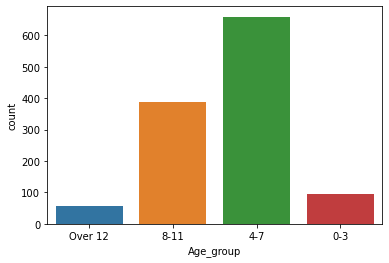

In [660]:
#Graph
sns.countplot(x='Age_group', data=df)

#### 3.2. Rating
##### 3.2.1. Describe

In [661]:
df.describe()

,Rating_out_of_5,No_of_Ratings
count,1200.000000,1200.000000
mean,4.788667,103.154050
std,0.101473,236.572631
min,4.000000,1.003000
25%,4.700000,2.165750
50%,4.800000,4.145000
75%,4.900000,13.525750
max,5.000000,993.000000


##### 3.2.2. Histplot

<AxesSubplot:xlabel='Rating_out_of_5', ylabel='Count'>

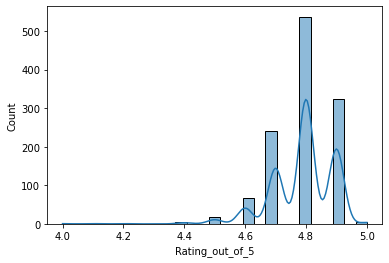

In [662]:
sns.histplot(x='Rating_out_of_5', data=df, kde=True)

<AxesSubplot:xlabel='No_of_Ratings', ylabel='Count'>

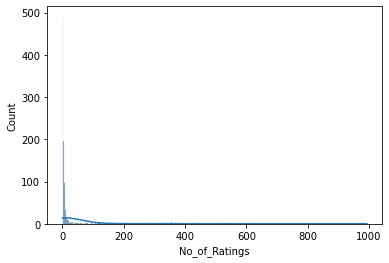

In [663]:
sns.histplot(x='No_of_Ratings', data=df, kde=True)

##### 3.2.3. Weighted Rating

IMDB's weighted rating

weighted_rating=(v/(v+m))* r + (m/(v+m))* c

v: The number of votes an individual book was rated

m: Minimum number of votes to give a rating

r: The average rating for individual movies

c: The average rating for the entire movie

In [664]:
c=df['Rating_out_of_5'].mean()
m=df['No_of_Ratings'].quantile(0.6) #60% of the total votes

In [665]:
def weighted_rating(x):
    v=x['No_of_Ratings']
    r=x['Rating_out_of_5']
    c=df['Rating_out_of_5'].mean()
    m=df['No_of_Ratings'].quantile(0.6)
    
    return round(((v/(v+m))* r) + ((m/(v+m))* c),2)

In [666]:
df['weighted_rating']=df.apply(weighted_rating, axis=1)

<AxesSubplot:xlabel='weighted_rating', ylabel='Count'>

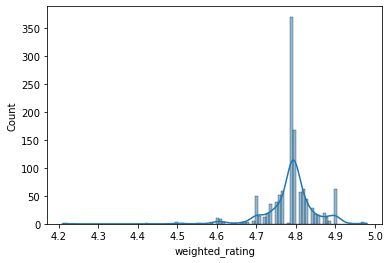

In [667]:
sns.histplot(x='weighted_rating', data=df, kde=True)

#### 3.3. Description
##### 3.3.1. Text cleaning, Feature vectorizer

In [668]:
#Null data
df[df['Description'].isna()==True]
#Fetching book descriptions from Amazon to fill the null data. 
null_text="This book is perfect for toddlers who are learning how to use scissors! The book contains over 40 exercises and crafts that help kids learn to use scissors safely. Projects include animals, patterns and shapes to cut out! The fun doesn't stop there! Kids can color and use their creations to make jewelry (bracelets), decorate their rooms or give as gifts!"
df['Description'].fillna(null_text, inplace=True)

In [669]:
def strip_n(x):
    return x.strip('\n')

In [670]:
def remove_string(x):
    return x.replace(u'\xa0', u" ")

In [671]:
df['text']=df['Description'].apply(lambda x: remove_string(x))

In [672]:
df['text']=df['Description'].apply(lambda x: strip_n(x))

In [673]:
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# lemmatization
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]
# Stop words-> convert to lowercase-> tokenize words-> lemmatization
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [674]:
tfidf_vect=TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2),min_df=0.05, max_df=0.85)
feature_vect=tfidf_vect.fit_transform(df['text'])

##### 3.3.2. KMeans Clustering

In [675]:
def visualize_silhouette(cluster_lists, X_features): 
    
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
       
    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster, max_iter=10000, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        
        axs[ind].set_yticks([])  
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

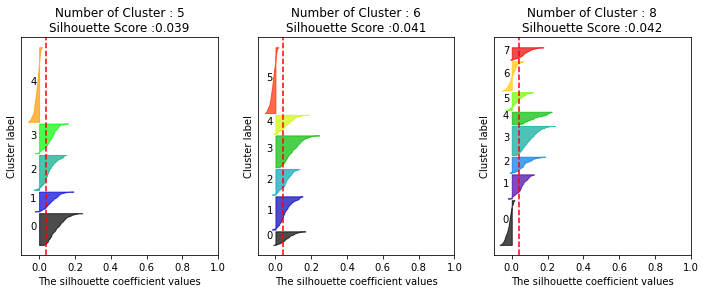

In [676]:
cluster_lists=[5,6,8]
visualize_silhouette(cluster_lists, feature_vect)  #k=6

In [677]:
km_cluster=KMeans(n_clusters=6, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

df['Kmeans_label']=cluster_label

<AxesSubplot:xlabel='Kmeans_label', ylabel='count'>

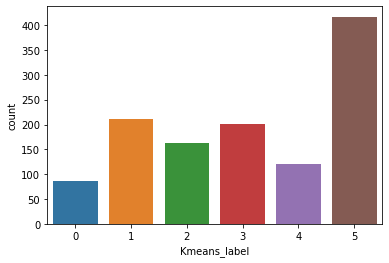

In [678]:
sns.countplot(x='Kmeans_label', data=df)

In [679]:
df[df['Kmeans_label']==0][['Name', 'text', 'Age_group']][:8]

,Name,text,Age_group
10,Percy Jackson and the Olympians 5 Book Paperba...,All five books in the blockbuster Percy Jackso...,8-11
14,"Magic Tree House Boxed Set, Books 1-4: Dinosau...",Visit the magic tree house and start a time tr...,8-11
29,Dr. Seuss's Beginner Book Collection (Cat in t...,Celebrate back-to-school—no matter what that l...,4-7
31,Harry Potter: The Illustrated Collection (Book...,The first three books in the Harry Potter seri...,8-11
77,The Chronicles of Narnia Adult Box Set,"For over 60 years, readers of all ages have be...",4-7
78,My Big Fat Zombie Goldfish Boxed Set: (My Big ...,This must-have paperback boxed set includes th...,8-11
80,Harry Potter Books 1-7 Special Edition Boxed Set,A new special edition boxed set of the complet...,8-11
101,The Heroes of Olympus Paperback Boxed Set (10t...,All five books in the #1 New York Times bestse...,8-11


In [680]:
df[df['Kmeans_label']==1][['Name', 'text', 'Age_group']][:8]

,Name,text,Age_group
3,My First Learn to Write Workbook: Practice for...,A lifetime of communication skills starts here...,4-7
16,School Zone - Big Preschool Workbook - Ages 3 ...,School Zone products shipped and sold by Amazo...,4-7
18,First Little Readers Parent Pack: Guided Readi...,Jumpstart reading success with this big collec...,4-7
33,200 Must Know Sight Words Activity Workbook: L...,Top 200 most common sight words for kids!Are y...,4-7
46,School Zone - Multiplication 0-12 Flash Cards ...,Find our complete line of educational resource...,4-7
50,Trace Letters: Alphabet Handwriting Practice w...,Ultimate Handwriting Practice Workbook for you...,4-7
61,This Is How We Do It: One Day in the Lives of ...,"In Japan, Kei plays Freeze Tag, while in Ugand...",4-7
64,Awesome Science Experiments for Kids: 100+ Fun...,Hands-on projects to get kids ages 5 to 10 exc...,4-7


In [681]:
df[df['Kmeans_label']==2][['Name', 'text', 'Age_group']][:8]

,Name,text,Age_group
0,We Were Liars,"#1 NEW YORK TIMES BESTSELLER • A modern, sophi...",Over 12
8,Grumpy Monkey,The hilarious #1 New York Times bestselling pi...,4-7
15,The Dark Secret (Wings of Fire Graphic Novel #...,The #1 New York Times bestselling Wings of Fir...,8-11
26,The Complete Cookbook for Young Chefs: 100+ Re...,The #1 New York Times Best Seller!An Amazon Be...,8-11
27,The Office: A Day at Dunder Mifflin Elementary,The instant #1 New York Times bestseller!Disco...,4-7
40,How to Catch a Unicorn,The #1 New York Times bestseller! Try to catc...,4-7
44,Little Leaders: Bold Women in Black History (V...,A NEW YORK TIMES INSTANT BESTSELLER!A USA TOD...,8-11
47,The Wonderful Things You Will Be,The New York Times bestseller that celebrates ...,4-7


In [682]:
df[df['Kmeans_label']==3][['Name', 'text', 'Age_group']][:8]

,Name,text,Age_group
1,Harry Potter Paperback Box Set (Books 1-7),"Now for the first time ever, J.K. Rowling’s se...",8-11
6,Bronco and Friends: A Party to Remember,NEW YORK TIMES BESTSELLER • Heisman Trophy win...,4-7
11,The Deep End (Diary of a Wimpy Kid Book 15),"An instant #1 USA Today, Wall Street Journal, ...",8-11
21,Of Thee I Sing: A Letter to My Daughters,"Barack Obama delivers a tender, beautiful lett...",4-7
23,Kamala and Maya’s Big Idea,INSPIRED BY A TRUE STORY FROM THE CHILDHOOD OF...,4-7
38,The Ballad of Songbirds and Snakes (A Hunger G...,Ambition will fuel him. Competition will drive...,Over 12
43,Joey: The Story of Joe Biden,“(Jill) Biden’s anecdotal portrait of her spou...,4-7
45,Chicka Chicka Boom Boom (Board Book),The complete edition of the bestselling childr...,0-3


In [683]:
df[df['Kmeans_label']==4][['Name', 'text', 'Age_group']][:8]

,Name,text,Age_group
4,I Love You to the Moon and Back,Show your child just how strong your love is e...,4-7
7,My First Library : Boxset of 10 Board Books fo...,The amazing boxset contains a set of 10 well-r...,4-7
9,The Very Hungry Caterpillar,"THE all-time classic picture book, from genera...",0-3
36,Llama Llama I Love You,Beloved storyteller Anna Dewdney shows young c...,0-3
41,Potty Time! (Daniel Tiger's Neighborhood) (Dan...,Learning to use the potty is something to cele...,0-3
51,Goodnight Moon,"In this classic of children's literature, belo...",0-3
74,P is for Potty! (Sesame Street) (Lift-the-Flap),Sesame Street's Elmo tells little girls and bo...,0-3
84,A Little SPOT of Emotion Box Set (8 Books: Ang...,This box set includes 8 Emotion Books: A Littl...,4-7


In [684]:
df[df['Kmeans_label']==5][['Name', 'text', 'Age_group']][:10]

,Name,text,Age_group
2,If Animals Kissed Good Night,Don't miss the other books in this adorable se...,4-7
5,Superheroes Are Everywhere,From Vice President Kamala Harris comes a pict...,4-7
12,Cat Kid Comic Club: From the Creator of Dog Man,A pioneering new graphic novel series by Dav P...,8-11
13,The Ickabog,"From J.K. Rowling, a warm, fast-paced, funny f...",8-11
17,Paint by Sticker Kids: Zoo Animals: Create 10 ...,Paint a zoo full of animals with stickers!Step...,4-7
19,"Bob Books, Set 1: Beginning Readers",Teach a child letter sounds with Bob Books Set...,4-7
20,"Brown Bear, Brown Bear, What Do You See?","A big happy frog, a plump purple cat, a handso...",4-7
22,Dog Man: Grime and Punishment: From the Creato...,The mayor has had enough of Dog Man's shenanig...,8-11
24,Harry Potter and the Sorcerer's Stone: MinaLim...,A dazzling new edition of J.K. Rowling's Harry...,8-11
25,Love You Forever,A young woman holds her newborn sonAnd looks ...,4-7


In [685]:
cluser_centers=km_cluster.cluster_centers_
cluster_centers.shape

(6, 210)

In [686]:
def get_cluster_key(model, data, feature_names, clusters_num, top_n_features=10):
    cluster_key={}
    center_feature_order_idx=model.cluster_centers_.argsort()[:,::-1]
    for cluster_num in range(clusters_num):
        cluster_key[cluster_num]={}
        cluster_key[cluster_num]['cluster']=cluster_num
        
        top_feature_idx=center_feature_order_idx[cluster_num, :top_n_features]
        top_features=[feature_names[idx] for idx in top_feature_idx]
        top_feature_values=model.cluster_centers_[cluster_num, top_feature_idx].tolist()
        
        cluster_key[cluster_num]['top_features']=top_features
        cluster_key[cluster_num]['top_features_value']=top_feature_values
        
    return cluster_key           

In [687]:
def print_cluster_key(cluster_key):
    for cluster_num, cluster_keys in cluster_key.items():
        print(f"#### Cluster:",{cluster_num})
        print(f"Top features:", cluster_key[cluster_num]['top_features'])
        print("-------------------------------------------")
              

In [688]:
feature_names=tfidf_vect.get_feature_names()
cluster_key=get_cluster_key(model=km_cluster, data=df, feature_names=feature_names, clusters_num=6, top_n_features=10)
print_cluster_key(cluster_key)

#### Cluster: {0}
Top features: ['set', 'series', 'boxed', 'book', 'boxed set', 'box', 'reader', 'adventure', 'new', 'bestselling']
-------------------------------------------
#### Cluster: {1}
Top features: ['kid', 'child', 'learning', 'help', 'workbook', 'book', 'practice', 'fun', 'activity', 'skill']
-------------------------------------------
#### Cluster: {2}
Top features: ['new', 'york', 'new york', 'york time', 'time', 'time bestselling', 'bestselling', 'book', '1 new', 'author']
-------------------------------------------
#### Cluster: {3}
Top features: ['’', '’ s', 's', '”', '“', 'book', 'new', 'time', 't', '’ t']
-------------------------------------------
#### Cluster: {4}
Top features: ['baby', 'little', 'book', 'board', 'board book', 'love', 'child', 'perfect', 'toddler', 'gift']
-------------------------------------------
#### Cluster: {5}
Top features: ['book', 'story', 'child', 'day', 'ha', 'reader', 'friend', 'love', 'wa', 'world']
-------------------------------------

###### Findings
-Cluster 0: Set, Series books

-Cluster 1: Workbook for 4-7

-Cluster 2: NewYork Times Best seller

-Cluster 3: ?

-Cluster 4: Kid/Infant/Toddler

-Cluster 5: ?

--> Since the distinction between each cluster is unclear, I will try cosine similarity analysis.

##### 3.3.3. Cosine Similarity

In [689]:
feature_vect.shape

(1200, 210)

In [690]:
cosine_sim=linear_kernel(feature_vect, feature_vect)

In [691]:
indices=pd.Series(df.index, df['Name']).drop_duplicates()  

### 4. Model

In [692]:
#If the title is received, it will return a list of the top 30 books with the highest similarity.
def get_recommendation(name, cosine_sim=cosine_sim, data=df):
    idx=indices[name]
    idx_rank=cosine_sim[idx].argsort()[::-1]
    idx_top30=idx_rank[1:30]  
    age_group=data[data['Name']==name]['Age_group'].values[0]
    author=data[data['Name']==name]['Author'].values[0]
    recomm_df=data.loc[idx_top20,['Name', 'Author', 'text', 'weighted_rating','Age_group','Link']]
    recommendation_df=recomm_df[recomm_df['Age_group']==age_group][:5]
    
    return recommendation_df

In [701]:
recommendation_df=get_recommendation("Bronco and Friends: A Party to Remember")

In [702]:
recommendation_df

,Name,Author,text,weighted_rating,Age_group,Link
671,Last Stop on Market Street,Matt de la Peña,#1 New York Times Bestseller A USA Today Bests...,4.82,4-7,https://www.amazon.com/Last-Stop-Market-Street...
835,Duck and Hippo The Secret Valentine,Jonathan London,"Join Duck, Hippo, and their friends as they un...",4.80,4-7,https://www.amazon.com/Hippo-Secret-Valentine-...
403,"Ada Twist, Scientist",Andrea Beaty,A #1 New York Times Bestseller A Wall Street J...,4.83,4-7,https://www.amazon.com/Ada-Twist-Scientist-And...
808,I Want My Hat Back,Jon Klassen,A New York Times Best Illustrated Children's B...,4.76,4-7,https://www.amazon.com/I-Want-My-Hat-Back/dp/0...
1105,Speak Up,Miranda Paul,"When something really matters, one voice can m...",4.80,4-7,https://www.amazon.com/Speak-Up-Miranda-Paul/d...
